In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My\ Drive/Thesis/yasho #adjust file path accordingly in your drive

[Errno 2] No such file or directory: 'gdrive/My Drive/Thesis/yasho #adjust file path accordingly in your drive'
/content


In [ ]:
%cd Thesis/yasho
%ls

/content/gdrive/.shortcut-targets-by-id/1MajC_dl3lGrSNLdcScjHbqW6wN7tGOul/yasho
'3D-Semantic Segmentation Project.ipynb'   savedmod50ep.h5
 boston@                                   testing_groundtruth.tif
 checkpts/                                 testing.tif
 data.csv                                  training_groundtruth.tif
 myresults2.tif                            training.tif
 results_from_paper.tif                    volumedata.tif


In [ ]:
# %tensorflow_version 2.x

In [ ]:
# !pip install classification-models-3D
# !pip install efficientnet-3D
# !pip install segmentation-models-3D

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)    
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

#Encoder Block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Model Output
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)


    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)


    b1 = conv_block(p3, 256) 

    d1 = decoder_block(b1, s3, 128)
    d2 = decoder_block(d1, s2, 64)
    d3 = decoder_block(d2, s1, 32)


    
    activation = 'softmax'

    outputs = Conv3D(n_classes, 1, padding="same", activation=activation)(d3)  
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
my_model = build_unet((32,32,32,1), n_classes=2)

softmax


In [ ]:
print(my_model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 32, 32, 32,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32,   128        ['conv3d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
my_model.input_shape

(None, 32, 32, 32, 1)

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

2.11.0
2.11.0


In [ ]:
#Gpu Test
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np

from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
#!pip install matplotlib

In [ ]:
#Load images and truth values into patches
image = io.imread('training.tif') #gdrive/MyDrive/Colab Notebooks/boston/
img_patches = patchify(image, (32, 32, 32), step=32)  

mask = io.imread('training_groundtruth.tif') #gdrive/MyDrive/Colab Notebooks/boston/
mask_patches = patchify(mask, (32, 32, 32), step=32)  


In [ ]:
image.shape

(165, 768, 1024)

In [ ]:
#help(patchify)

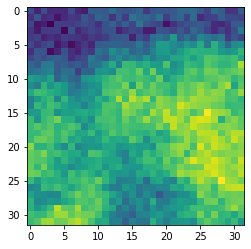

In [ ]:
plt.imshow(img_patches[1,2,3,:,:,7])

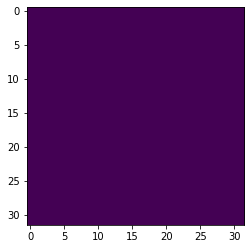

In [ ]:
plt.imshow(mask_patches[1,2,3,:,:,7])

In [ ]:
img_patches.shape

(5, 24, 32, 32, 32, 32)

In [ ]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)
print(input_mask.shape)  

(3840, 32, 32, 32)
(3840, 32, 32, 32)


In [ ]:
n_classes=2

In [ ]:
print("input_img : ", input_img.shape)

train_img = np.stack((input_img,)*1, axis=-1)
print("train_img : ", train_img.shape)

train_img = np.divide(train_img, 255) 
print("train_img/255 : ", train_img.shape)

print("input_mask : ", input_mask.shape)
train_mask = np.expand_dims(input_mask, axis=1)
print("train_mask exp dim: ", train_mask.shape)
print(np.unique(train_mask))
train_mask = np.divide(train_mask, 255)
print(np.unique(train_mask))

train_mask_cat = to_categorical(train_mask, num_classes = n_classes) #train_mask #


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.05, random_state = 2)

input_img :  (3840, 32, 32, 32)
train_img :  (3840, 32, 32, 32, 1)
train_img/255 :  (3840, 32, 32, 32, 1)
input_mask :  (3840, 32, 32, 32)
train_mask exp dim:  (3840, 1, 32, 32, 32)
[  0 255]
[0. 1.]


In [ ]:
# print(X_train.shape)
# print(X_train[-1])


In [ ]:
#Evaluation metric
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
#Model Parameters
patch_size = 32
channels=1

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [ ]:
model = build_unet((patch_size,patch_size,patch_size,channels), n_classes=n_classes)

softmax


In [ ]:
model.compile(optimizer = optim, loss=dice_coefficient_loss, metrics=dice_coefficient)
print(model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_15 (Conv3D)             (None, 32, 32, 32,   896         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32, 32, 32,   128        ['conv3d_15[0][0]']              
 ormalization)                  32)                                                           

In [ ]:
print(model.input_shape)
print(X_train.shape)
print(model.output_shape)
print(y_train.shape)
y_train = np.squeeze(y_train,axis=1)
print(y_train.shape)
print("-------------------")
print(X_train.max())
print(X_test.max())

(None, 32, 32, 32, 1)
(3648, 32, 32, 32, 1)
(None, 32, 32, 32, 2)
(3648, 1, 32, 32, 32, 2)
(3648, 32, 32, 32, 2)
-------------------
0.9568627450980393
0.9372549019607843


In [ ]:
# tf.keras.callbacks.ModelCheckpoint(
#     filepath,
#     monitor: str = "val_loss",
#     verbose: int = 1,
#     save_best_only: bool = False,
#     save_weights_only: bool = False,
#     mode: str = "auto",
#     save_freq="epoch",
#     options=None,
#     initial_value_threshold=None,
#     **kwargs
# )

EPOCHS = 100 #too big, colab crashes
checkpoint_filepath = '/checkpts/check.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False)

In [ ]:
#Fit the model
checkpoint_filepath = './checkpts/check.h5'

history=model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = [model_checkpoint_callback])

Epoch 1/50
114/114 [==============================] - 75s 548ms/step - loss: 0.1293 - dice_coefficient: 0.8707 - val_loss: 0.8695 - val_dice_coefficient: 0.1305
Epoch 2/50
114/114 [==============================] - 63s 556ms/step - loss: 0.0741 - dice_coefficient: 0.9259 - val_loss: 0.8882 - val_dice_coefficient: 0.1118
Epoch 3/50
114/114 [==============================] - 64s 565ms/step - loss: 0.0574 - dice_coefficient: 0.9426 - val_loss: 0.6100 - val_dice_coefficient: 0.3900
Epoch 4/50
114/114 [==============================] - 65s 572ms/step - loss: 0.0499 - dice_coefficient: 0.9501 - val_loss: 0.6279 - val_dice_coefficient: 0.3721
Epoch 5/50
114/114 [==============================] - 65s 573ms/step - loss: 0.0404 - dice_coefficient: 0.9596 - val_loss: 0.1452 - val_dice_coefficient: 0.8548
Epoch 6/50
114/114 [==============================] - 66s 575ms/step - loss: 0.0353 - dice_coefficient: 0.9647 - val_loss: 0.0402 - val_dice_coefficient: 0.9598
Epoch 7/50
114/114 [==============

In [ ]:
#Save model for future use
model.save('checkpts/savedmod50ep.h5')

In [ ]:
%ls

boston@           testing_groundtruth.tif   training.tif
checkpts/         testing.tif               Trying_2.ipynb
results_test.tif  training_groundtruth.tif  volumedata.tif


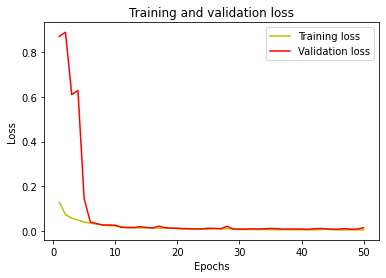

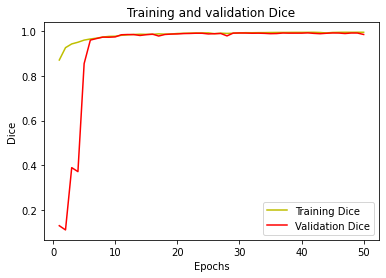

In [ ]:
#Visualisation
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
%ls

'3D-Semantic Segmentation Project.ipynb'   savedmod50ep.h5
 boston@                                   testing_groundtruth.tif
 checkpts/                                 testing.tif
 data.csv                                  training_groundtruth.tif
 myresults2.tif                            training.tif
 results_from_paper.tif                    volumedata.tif


In [ ]:
#loading model
from keras.models import load_model
my_model = load_model('savedmod50ep.h5', compile=False)


In [ ]:

print(X_test.shape)

#Predicting on testing subdataset
y_pred=my_model.predict(X_test)
print(y_pred.shape)

# y_pred_argmax=np.argmax(y_pred, axis=4)
# print(y_pred_argmax.shape)
y_test=np.squeeze(y_test,axis=1)
print(y_test.shape)
# y_test_argmax = np.argmax(y_test, axis=4)
# print(y_test_argmax.shape)


(192, 32, 32, 32, 1)


In [ ]:
print(y_pred.shape)
print(y_test.shape)

# y_test_argmax=np.squeeze(y_test_argmax,axis=1)

# y_test_argmax = np.divide(y_test_argmax, 255)
#print(y_test_argmax.shape)
print(np.unique(y_pred))
print(np.unique(y_test))

y_test_argmax = np.argmax(y_test, axis=4)
y_pred_argmax = np.argmax(y_pred, axis=4)

print(y_pred.shape)
print(y_test.shape)
print(np.unique(y_pred))
print(np.unique(y_test))

(192, 32, 32, 32, 2)
(192, 32, 32, 32, 2)
[4.0307157e-11 4.5097207e-11 5.0694678e-11 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0. 1.]
(192, 32, 32, 32, 2)
(192, 32, 32, 32, 2)
[4.0307157e-11 4.5097207e-11 5.0694678e-11 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0. 1.]


In [ ]:
%ls

boston@    myresults2.tif          testing_groundtruth.tif   training.tif
checkpts/  myresults.tif           testing.tif               Trying_2.ipynb
data.csv   results_from_paper.tif  training_groundtruth.tif  volumedata.tif


In [ ]:
#evaluation metric on testing sub-dataset
print(dice_coefficient(y_test, y_pred))

tf.Tensor(0.9847906, shape=(), dtype=float32)


In [ ]:
#visualisation on random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)


test_pred = my_model.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=4)[0,:,:,:]

ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(ground_truth_argmax.shape)

1/1 [==============================] - 0s 22ms/step
(32, 32, 32)


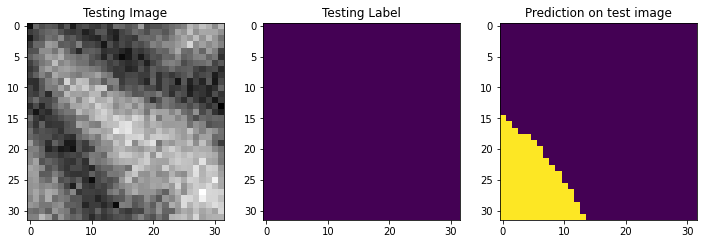

In [ ]:
#Plot individual slices from test predictions for verification
slice = random.randint(0, ground_truth_argmax.shape[2]-1)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[slice,:,:])
plt.show()

In [ ]:
#Final Prediction on 'testing.tif'   
large_image = io.imread('testing.tif')
patches = patchify(large_image, (32, 32, 32), step=32)
print(large_image.shape)
print(patches.shape)

NameError: ignored

In [ ]:
#Prediction iteratively
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,), axis=-1)
      single_patch_3ch = single_patch_3ch/255.
      single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)

1/1 [==============================] - 0s 59ms/step


In [ ]:
#prediction to numpy
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(3840, 32, 32, 32)


In [ ]:

predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(5, 24, 32, 32, 32, 32)


In [ ]:
#saving the output because colab used to crash when unpatchifying the prediction
np.savetxt('data.csv',predicted_patches_reshaped.reshape(122880,1024))

NameError: ignored

In [ ]:
#new session after colab crashes
import numpy as np

Checking if what im getting even makes sense

In [ ]:
predicted_patches_reshaped_im = np.multiply(predicted_patches_reshaped,255) 

In [ ]:
image_useful_im = np.multiply(image_useful,255) 

In [ ]:
predicted_patches_reshaped_im = predicted_patches_reshaped_im.reshape((5,24,32,32,32,32))

In [ ]:
image_useful_im = image_useful_im.reshape((5,24,32,32,32,32))

In [ ]:
reconstructed_image = unpatchify(predicted_patches_reshaped_im, (160,768,1024)) #I had to cut last 5 images since during patchifying we lost some data
print(reconstructed_image.shape)

(160, 768, 1024)


In [ ]:
reconstructed_image_test = unpatchify(image_useful_im, (160,768,1024)) #I had to cut last 5 images since during patchifying we lost some data
print(reconstructed_image_test.shape)

(160, 768, 1024)


In [ ]:
print(reconstructed_image.dtype)
print(np.unique(reconstructed_image))
print(np.count_nonzero(reconstructed_image == 255))
print(np.count_nonzero(reconstructed_image == 0))

float64
[  0. 255.]
6781988
119047132


In [ ]:
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)
from tifffile import imsave
imsave('myresultsJac.tif', reconstructed_image)

uint8


<ipython-input-108-163717b1154f>:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('myresultsJac.tif', reconstructed_image)


In [ ]:
print(reconstructed_image_test.dtype)
print(np.unique(reconstructed_image_test))
print(np.count_nonzero(reconstructed_image_test == 255))
print(np.count_nonzero(reconstructed_image_test == 0))

float64
[  0. 255.]
6756015
119073105


In [ ]:
reconstructed_image_test=reconstructed_image_test.astype(np.uint8)
print(reconstructed_image_test.dtype)
from tifffile import imsave
imsave('myresultsJacTest.tif', reconstructed_image_test)

uint8


<ipython-input-110-75f6f7ece1fe>:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('myresultsJacTest.tif', reconstructed_image_test)


In [ ]:
print(predicted_patches_reshaped.shape)

(122880, 1024)


In [ ]:
predicted_patches_reshaped = predicted_patches_reshaped.reshape((5,24,32,32,32,32))

In [ ]:
predicted_patches_reshaped.shape

(5, 24, 32, 32, 32, 32)

In [ ]:
#converting binary masks to black and white image prediction
predicted_patches_reshaped = np.multiply(predicted_patches_reshaped,255) 

In [ ]:
reconstructed_image = unpatchify(predicted_patches_reshaped, (160,768,1024)) #I had to cut last 5 images since during patchifying we lost some data
print(reconstructed_image.shape)

(160, 768, 1024)


In [ ]:
print(reconstructed_image.dtype)

float64


In [ ]:
np.unique(reconstructed_image)

array([  0., 255.])

In [ ]:
np.count_nonzero(reconstructed_image == 255)

6781988

In [ ]:
np.count_nonzero(reconstructed_image == 0)

119047132

In [ ]:
#converting it to uint8 for opening file in other viewing formats
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [ ]:
#exporting the results in tif
from tifffile import imsave
imsave('myresults3.tif', reconstructed_image)

<ipython-input-53-0772302d674e>:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('myresults3.tif', reconstructed_image)


In [ ]:
print(np.unique(reconstructed_image))

[  0 255]


**BenchMarking**

In [ ]:
%ls

'3D-Semantic Segmentation Project.ipynb'   savedmod50ep.h5
 boston@                                   testing_groundtruth.tif
 checkpts/                                 testing.tif
 data.csv                                  training_groundtruth.tif
 myresults2.tif                            training.tif
 results_from_paper.tif                    volumedata.tif


In [ ]:
%cd gdrive/My\ Drive/Thesis/yasho #change file paths accordingly

[Errno 2] No such file or directory: 'gdrive/My Drive/Thesis/yasho'
/content/gdrive/.shortcut-targets-by-id/1MajC_dl3lGrSNLdcScjHbqW6wN7tGOul/yasho


In [ ]:
%ls

'3D-Semantic Segmentation Project.ipynb'   results_from_paper.tif
 boston@                                   savedmod50ep.h5
 checkpts/                                 testing_groundtruth.tif
 data.csv                                  testing.tif
 myresults2.tif                            training_groundtruth.tif
 myresultsJacTest.tif                      training.tif
 myresultsJac.tif                          volumedata.tif


In [ ]:
#predicted_patches_reshaped = np.loadtxt("data.csv")

In [ ]:
image = io.imread('testing_groundtruth.tif') #gdrive/MyDrive/Colab Notebooks/boston/
image.shape
img_patches = patchify(image, (32, 32, 32), step=32)

In [ ]:
img_patches.shape
image_useful = np.reshape(img_patches, (160, 768, 1024))

In [ ]:
imag = io.imread('myresults2.tif') #gdrive/MyDrive/Colab Notebooks/boston/
predicted_patches_reshaped = patchify(imag, (32, 32, 32), step=32)

In [ ]:
predicted_patches_reshaped.shape
predicted_patches_reshaped = np.reshape(predicted_patches_reshaped, (160, 768, 1024))

In [ ]:
print(image_useful.shape)
print(predicted_patches_reshaped.shape)

(160, 768, 1024)
(160, 768, 1024)


In [ ]:
# image_useful = np.reshape(image_useful, (122880, 1024))
# image_useful.shape

(122880, 1024)

In [ ]:
image_useful = np.divide(image_useful, 255)

In [ ]:
predicted_patches_reshaped = np.divide(predicted_patches_reshaped, 255)

In [ ]:
image_useful.shape

(160, 768, 1024)

In [ ]:
image_useful = np.reshape(image_useful, (122880, 1024))

In [ ]:
print(np.unique(predicted_patches_reshaped))
print(np.unique(image_useful))

[0. 1.]
[0. 1.]


In [ ]:
true_labels = image_useful
pred_labels = predicted_patches_reshaped

In [ ]:
# True Positive (TP): we predict a label of 1 (positive), and the true
TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
 
# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
 
# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
 
# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

In [ ]:
print("tp: ", TP)
print("tn: ", TN)
print("fp: ", FP)
print("fn: ", FN)

tp:  5849145
tn:  118140262
fp:  932843
fn:  906870


In [ ]:
def jaccardCoeff(tp, fn, fp):
  coeff = tp/(tp+fn+fp)
  return coeff

In [ ]:
jaccardCoeff(TP, FN, FP)

0.7607300069789298